# Churn:
---

In [ ]:
ls

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn.apionly as sns
import matplotlib.pyplot as plt
from sklearn import tree, model_selection, metrics
%matplotlib inline
slc = lambda x: [*range(x)] + [*range(-x, 0)]

---
## Data Prep:
---

In [3]:
trns = pd.read_csv('counts.csv.gz')
trns.rename(columns = {'date':'datebin','count':'trns'}, inplace = True)
trns['tid'] = trns.account + trns.datebin.astype(str)
trns.iloc[slc(2), :-1]

,account,datebin,trns
0,5e0a5eb5575517efdddb2799c90e2e9b,2017-08-16,56
1,a04e063493c55bc6cecd9056712e9e47,2017-08-16,180
1934026,404a1cac5f1d2bd292ece1e435b4f0d3,2019-03-15,17
1934027,ab1317dd5bf062ab4df87248d4ed5bfd,2019-03-15,10


In [4]:
spend = pd.read_csv('spend.csv.gz')
spend.date = pd.to_datetime(spend.date, unit = 's').dt.date
spend.sort_values('date', inplace = True)
spend.reset_index(drop = True, inplace = True)
spend.rename(columns = {'date':'datebin','amount':'spend'}, inplace = True)
spend['tid'] = spend.account + spend.datebin.astype(str)
spend.iloc[slc(2), :-1]

,account,datebin,spend
0,a04e063493c55bc6cecd9056712e9e47,1973-04-05,730.070453
1,5e0a5eb5575517efdddb2799c90e2e9b,2017-08-16,15.144020
1934133,f9d9f6c9434d540ef4997706bacf21b5,2019-03-15,25.550035
1934134,04aa55b1463f98f26d220ffb618b969b,2019-03-15,35.063581


In [5]:
spend = spend[spend.datebin > pd.to_datetime('2000-01-01').date()];

In [7]:
len(spend.account.unique())

10001

In [8]:
spend.spend.sum()

583791917.80379725

In [6]:
rdat = spend.merge(trns[['tid', 'trns']], on = ['tid'], how = 'left').drop(['tid'], axis = 1)
rdat.trns.fillna(0, inplace = True)
rdat.trns = rdat.trns.astype(int)
assert(len(rdat)==len(spend))
spend, trns = None, None
rdat.iloc[slc(2)]

,account,datebin,spend,trns
0,5e0a5eb5575517efdddb2799c90e2e9b,2017-08-16,15.144020,56
1,dc58edfd3350a826391f35fd00b68e80,2017-08-16,11.002675,14
1934132,f9d9f6c9434d540ef4997706bacf21b5,2019-03-15,25.550035,72
1934133,04aa55b1463f98f26d220ffb618b969b,2019-03-15,35.063581,0


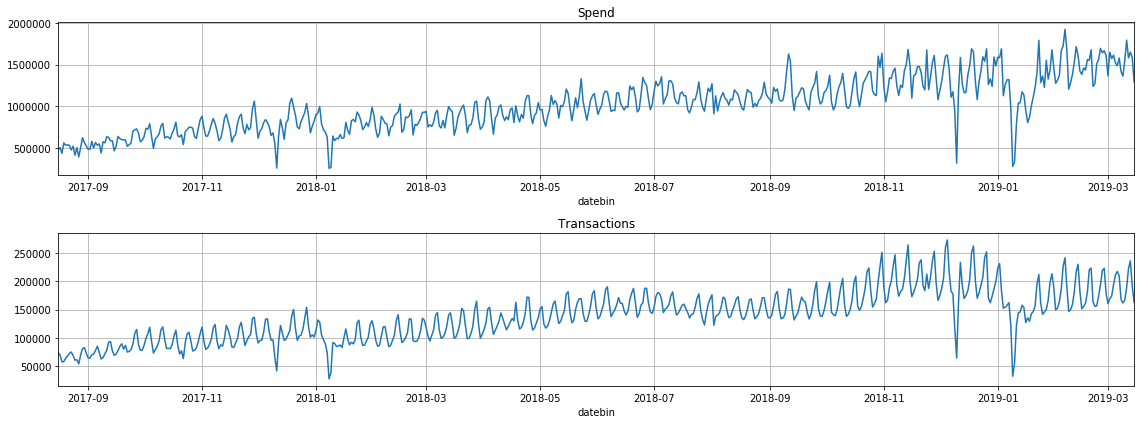

In [7]:
fix, axes = plt.subplots(2, 1, figsize = (16, 6))
rdat.groupby('datebin').spend.sum().plot(ax = axes[0]);
rdat.groupby('datebin').trns.sum().plot(ax = axes[1]);
titles = ('Spend','Transactions')
[(ax.grid(), ax.set_title(title)) for ax, title in zip(axes, titles)];
plt.tight_layout();

---
## Define Churn:
---

In [8]:
diam = rdat.query('trns > 0').groupby('account').datebin.agg([np.min, np.max]).reset_index()
diam['diam'] = (diam.amax - diam.amin).dt.days
dat = rdat.merge(diam, on = ['account'], how = 'left')
dat = dat[~dat.amin.isnull()]
dat.diam = dat.diam.fillna(0).astype(int)
dat['t'] = (dat.datebin - dat.datebin.min()).dt.days.astype(int)
dat['days_in'] = (dat.datebin - dat.amin).dt.days.astype(int)
dat['days_out'] = (dat.amax - dat.datebin).dt.days.astype(int)
dat['days_dead'] = (dat.datebin.max() - dat.amax).dt.days.astype(int)
dat['churned'] = (dat.days_dead > 90).astype(int)
dat['birth'] = (dat.days_in == 0.0).astype(int)
dat['death'] = (dat.days_out == 0.0).astype(int)
dat['flux'] = dat.birth - dat.death
dat['turbulance'] = dat.death + dat.birth
dat = dat.merge(pd.DataFrame(dat.groupby('t').flux.sum()).reset_index(), on = 't', how = 'left', suffixes = ['', '_del'])
dat = dat.merge(pd.DataFrame(dat.groupby('t').flux.sum().cumsum()).reset_index(), on = 't', suffixes = ['', '_cum'])
pop0 = len(dat[dat.t < 90].account.unique())
dat['population'] = dat.flux_cum + pop0
dat['churn'] = dat.death / dat.population
dat.iloc[slc(3)]

,account,datebin,spend,trns,amin,amax,diam,t,days_in,days_out,days_dead,churned,birth,death,flux,turbulance,flux_del,flux_cum,population,churn
0,5e0a5eb5575517efdddb2799c90e2e9b,2017-08-16,15.144020,56,2017-08-16,2018-11-10,451,0,0,451,125,1,1,0,1,1,1505,1505,6352,0.000000
1,dc58edfd3350a826391f35fd00b68e80,2017-08-16,11.002675,14,2017-08-16,2018-08-15,364,0,0,364,212,1,1,0,1,1,1505,1505,6352,0.000000
2,b2ede90b64b85b92553e02e18662ebad,2017-08-16,133.425343,17,2017-08-16,2018-12-24,495,0,0,495,81,0,1,0,1,1,1505,1505,6352,0.000000
1934022,f880cde0e9c95b3a90ae9203f908bf01,2019-03-15,70.672518,14,2017-12-16,2019-03-15,454,576,454,0,0,0,0,1,-1,1,-3825,0,4847,0.000206
1934023,62c7733c1026470cbff910d16d7202ec,2019-03-15,313.316720,68,2017-08-16,2019-03-15,576,576,576,0,0,0,0,1,-1,1,-3825,0,4847,0.000206
1934024,f9d9f6c9434d540ef4997706bacf21b5,2019-03-15,25.550035,72,2017-08-16,2019-03-15,576,576,576,0,0,0,0,1,-1,1,-3825,0,4847,0.000206


---
## Churn Trends:
---

In [9]:
datgrp = dat.groupby('datebin');

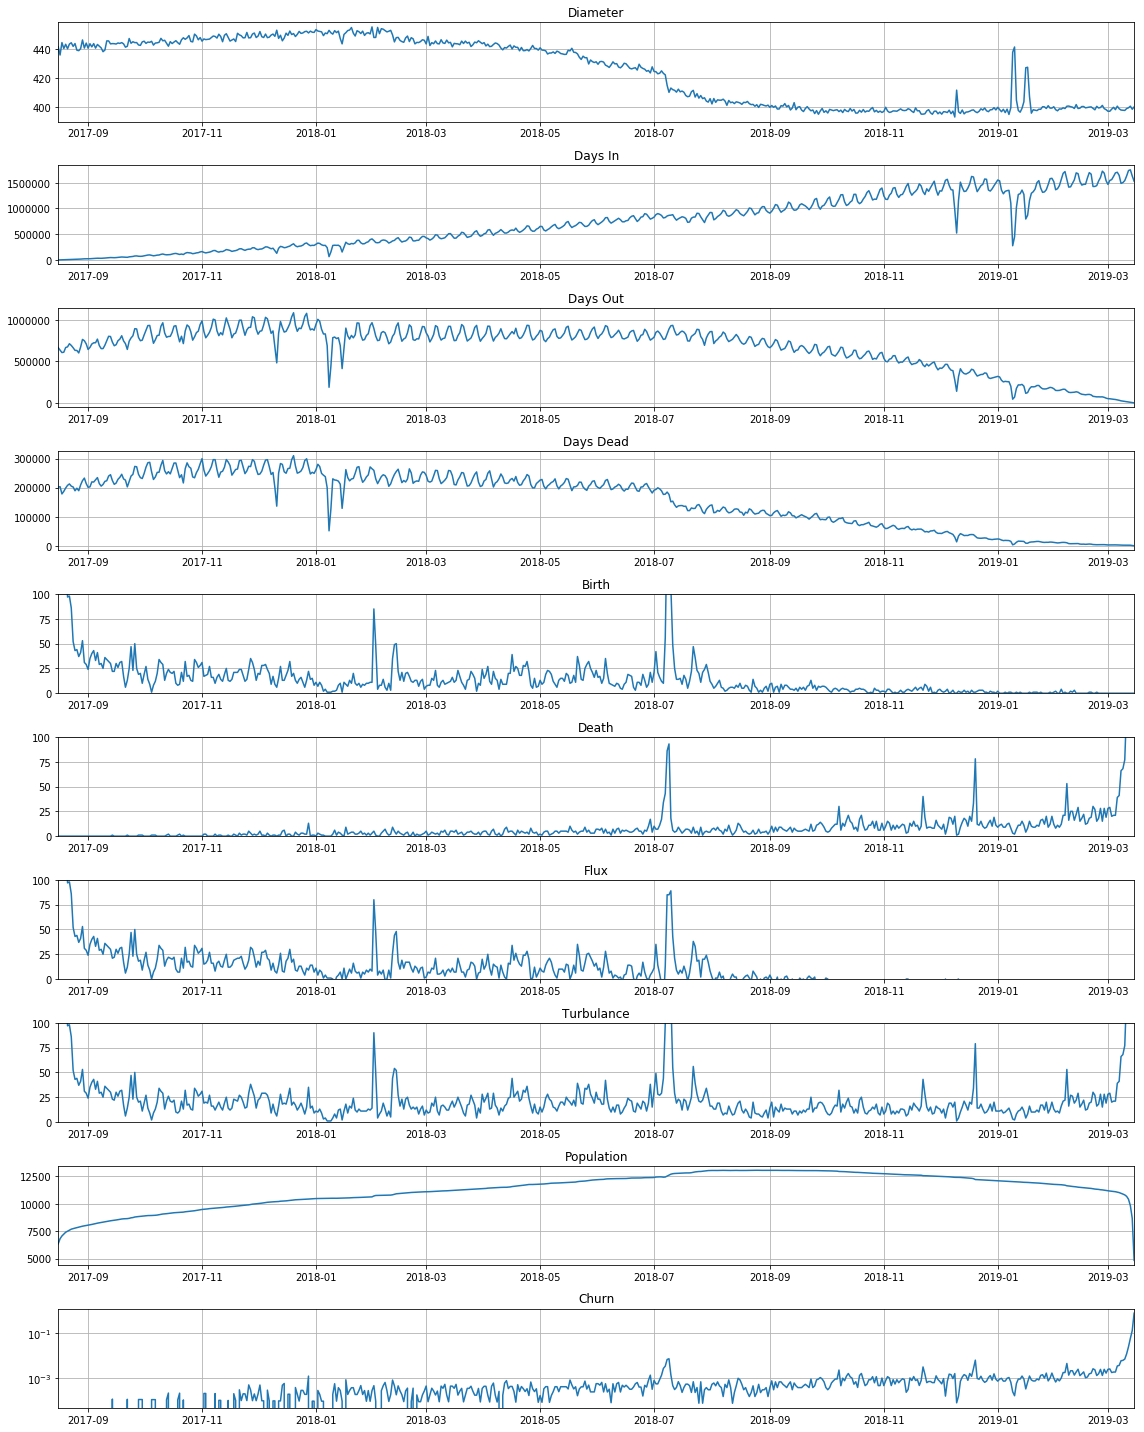

In [10]:
n = 10
fix, axes = plt.subplots(n, 1, figsize = (16, 2*n))
datgrp.diam.mean().plot(ax = axes[0], title = 'Diameter');
datgrp.days_in.sum().plot(ax = axes[1], title = 'Days In');
datgrp.days_out.sum().plot(ax = axes[2], title = 'Days Out');
datgrp.days_dead.sum().plot(ax = axes[3], title = 'Days Dead');
datgrp.birth.sum().plot(ax = axes[4], title = 'Birth');
datgrp.death.sum().plot(ax = axes[5], title = 'Death');
datgrp.flux.sum().plot(ax = axes[6], title = 'Flux');
datgrp.turbulance.sum().plot(ax = axes[7], title = 'Turbulance');
datgrp.population.max().plot(ax = axes[8], title = 'Population');
datgrp.churn.sum().plot(ax = axes[9], title = 'Churn');
for idx, ax in enumerate(axes):
    ax.set_xlabel('')
    ax.grid()
    if idx > 3 and idx < 8:
        ax.set_ylim((0, 100))
#axes[9].set_ylim((0, 0.01))
axes[9].set_yscale('log')
plt.tight_layout();

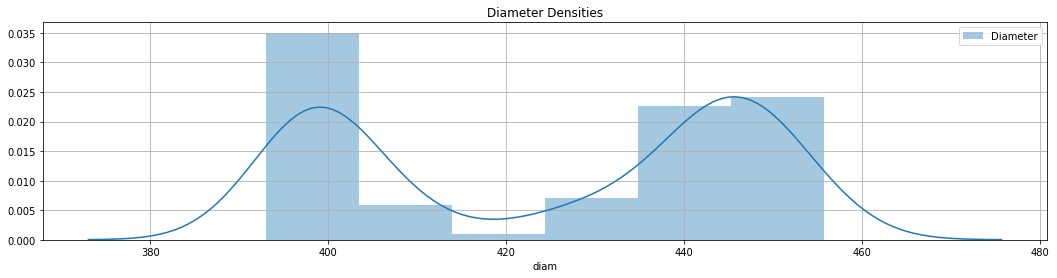

In [11]:
fix, ax = plt.subplots(1, 1, figsize = (18, 4))
sns.distplot(datgrp.diam.mean(), label='Diameter')
plt.title('Diameter Densities')
ax.grid()
plt.legend();

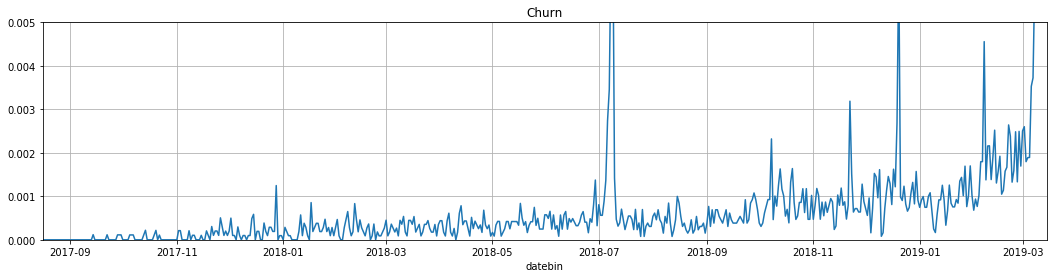

In [12]:
fix, ax = plt.subplots(1, 1, figsize = (18, 4))
datgrp.churn.sum().plot(ax = ax, title = 'Churn');
ax.set_ylim((0, 10**-2/2))
ax.grid()

In [13]:
churn = dat.groupby('t').churn.sum().fillna(0).reset_index()

In [14]:
linfits = []
for idx in range(0, churn.t.max(), 7):
    linfit = stats.linregress(churn[(churn.t > idx) & (churn.t < idx + 90)].t, churn[(churn.t > idx) & (churn.t < idx + 90)].churn)
    linfits += [linfit]
print(linfits[0], '\n', linfits[-1])
linfits = np.array(linfits)

LinregressResult(slope=7.322074933672859e-07, intercept=-4.7526883753188081e-06, rvalue=0.31510842997234234, pvalue=0.0026321282518444846, stderr=2.3643197614262865e-07) 
 LinregressResult(slope=0.65676785275181282, intercept=-377.5091352584916, rvalue=1.0, pvalue=0.0, stderr=0.0)


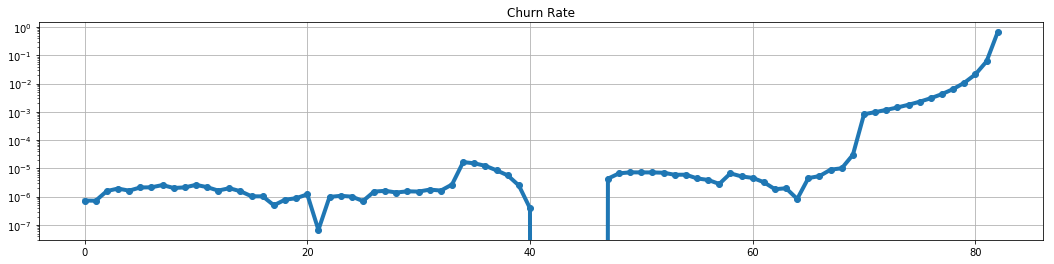

In [15]:
fix, ax = plt.subplots(1, 1, figsize = (18, 4))
ax.plot(linfits[:, 0], lw = 4, marker = 'o')
ax.set_title('Churn Rate')
ax.set_yscale('log')
ax.grid()

---
## Accounts At Risk:
---

In [16]:
cdat = dat[['churned','t','spend','trns']]
cdat.head(2)

,churned,t,spend,trns
0,1,0,15.144020,56
1,1,0,11.002675,14


In [17]:
X, y = cdat.iloc[:, 1:], cdat.churned

In [18]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 0)
dtree = tree.DecisionTreeClassifier(max_depth = 24, min_samples_leaf = 34)
dtree.fit(X_train, y_train)
predicted = dtree.predict(X_test)
probs = dtree.predict_proba(X_test)
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))
print('Accuracy: ', metrics.accuracy_score(y_test, predicted))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

ROC AUC:  0.759988198033
Accuracy:  0.803157765201
Confusion Matrix:
 [[752065  33041]
 [157308  24599]]
             precision    recall  f1-score   support

          0       0.83      0.96      0.89    785106
          1       0.43      0.14      0.21    181907

avg / total       0.75      0.80      0.76    967013



In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5, random_state = 0)
dtree = tree.DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 34)
dtree.fit(X_train, y_train)
predicted = dtree.predict(X_test)
probs = dtree.predict_proba(X_test)
print('ROC AUC: ', metrics.roc_auc_score(y_test, probs[:, 1]))
print('Accuracy: ', metrics.accuracy_score(y_test, predicted))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

ROC AUC:  0.788281781555
Accuracy:  0.812191769914
Confusion Matrix:
 [[778248   6858]
 [174755   7152]]
             precision    recall  f1-score   support

          0       0.82      0.99      0.90    785106
          1       0.51      0.04      0.07    181907

avg / total       0.76      0.81      0.74    967013



In [20]:
dtree = tree.DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 34)
dtree.fit(X, y)
predicted = dtree.predict(X)
probs = dtree.predict_proba(X)

In [21]:
dat['prob_churn'] = probs[:, 1]

### Likely To Churn:

In [22]:
dat.groupby('account').prob_churn.mean().reset_index().sort_values('prob_churn', ascending = False).head(10)

,account,prob_churn
5628,91ebd54fccc42003ca1d948406d11b72,0.519186
3229,521013b40ae63459338228e220356fb3,0.506914
1968,32f69f9acb5701c37499815ed3b0ece8,0.503635
9966,ff6cc8cadcb7457f9ddb2dd238a13733,0.503492
7930,cead1808d4ea0a56c6f9b97f0f26db1e,0.501072
2,000b2159adf33dcb44291291e0575122,0.499871
2935,4ae65e244883e778f1b6ae7db84312a5,0.496358
2525,4051bc06f599a532b94e141c48a36830,0.496347
7957,cf48a97c12a12d4db44f494f71ac28e1,0.492424
7706,c904539edf6d6bbfd3cb50c16bc07813,0.487573


### Likely To Churn (Excluding Churned):

In [23]:
dat[dat.churned == 0].groupby('account').prob_churn.mean().reset_index().sort_values('prob_churn', ascending = False).head(10)

,account,prob_churn
4595,9cb0908de6038ba3d58dbcecdf73ce90,0.479083
3554,7814794445bd56d7165bd7e36f5848dd,0.451669
3261,6ec8e768e0b45730aded85c8c3b2d3ee,0.443560
5294,b4b8bb02d7e22d8807de289538f9129d,0.439562
3382,72f68cd7fac70b8d60b871d2ec288644,0.438527
1147,26da9e781691f33ba16f160a61ad2152,0.435842
2032,44697a10b6e603f71c383c8b62c1001c,0.433125
4268,916780670b13feab23efa58ed17d9007,0.430540
1867,3f2b35e5573084e63dfbd47e26617aed,0.429994
877,1d11216fbf78ca9493925d623771b35c,0.428939


---
## Most valuable accounts:
---

In [24]:
dat.groupby('account').spend.sum().sort_values(ascending = False).reset_index()[:10]

,account,spend
0,e5a2f63c3ec4d5dfddcdc3abb6510aa5,8.947034e+06
1,040b3d8490a0be543c3394bb5c1c9653,4.144436e+06
2,2ae5455b659642e7196a63cde82f4789,3.625225e+06
3,cead1808d4ea0a56c6f9b97f0f26db1e,2.459842e+06
4,ce23b9bef1753ef640eb57922badb87d,2.385059e+06
5,11c49083489386acc215fcf47f980113,2.185171e+06
6,8ed2a1a1dd3fa79ac693e3f9a860e85e,1.940616e+06
7,d20baa74eb49da71fb00e7db2f134c62,1.640377e+06
8,c9a8834ce3851fe96bd738a034250a5e,1.592460e+06
9,a17a252b92833bf78d2a250d974f347a,1.591771e+06
